In [95]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 12)
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from xgboost import plot_importance, plot_tree

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
sample = pd.read_csv('Data/sample_submission.csv')
df = pd.concat([train, test], sort = False)

In [3]:
train.columns

Index(['date', 'store', 'item', 'sales'], dtype='object')

In [4]:
test.columns

Index(['id', 'date', 'store', 'item'], dtype='object')

In [5]:
print("train shape:", train.shape)
print("Test shape:", test.shape)

print(df.shape)
df.head()

train shape: (913000, 4)
Test shape: (45000, 4)
(958000, 5)


,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [6]:
def dumb_prediction(train, test, sample):
    for _, row in test.iterrows():
        item, store = row['item'], row['store']
        day, month = row.name.day, row.name.month
        itemandstore = (train.item == item) & (train.store == store)
        dayandmonth = (train.index.month == month) & (train.index.day == day)
        train_rows = train.loc[itemandstore & dayandmonth]
        pred_sales = int(round(train_rows.mean()['sales']))
        sample.at[row['id'], 'sales'] = pred_sales
    return sample

In [7]:
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)

In [8]:
def expand_df(df):
    data = df.copy()
    data['day'] = df['date'].dt.day
    data['month'] = df['date'].dt.month
    data['year'] = df['date'].dt.year
    data['dayofweek'] = df.date.dt.dayofweek
    return data

data = expand_df(df)
display(data)

grand_avg = data.sales.mean()
print(f"The grand average of sales in this dataset is {grand_avg:.4f}")

,date,store,item,sales,id,day,month,year,dayofweek
0,2013-01-01,1,1,13.0,NaN,1,1,2013,1
1,2013-01-02,1,1,11.0,NaN,2,1,2013,2
2,2013-01-03,1,1,14.0,NaN,3,1,2013,3
3,2013-01-04,1,1,13.0,NaN,4,1,2013,4
4,2013-01-05,1,1,10.0,NaN,5,1,2013,5
...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,27,3,2018,1
44996,2018-03-28,10,50,NaN,44996.0,28,3,2018,2
44997,2018-03-29,10,50,NaN,44997.0,29,3,2018,3
44998,2018-03-30,10,50,NaN,44998.0,30,3,2018,4


The grand average of sales in this dataset is 52.2503


In [12]:
train['date'] = pd.to_datetime(train['date'],infer_datetime_format=True)
train = expand_df(train)

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
store,,,,,,,,,,,,,,,,,,,,,
1,19.971522,53.148959,33.208105,19.956188,16.612815,53.060789,52.783680,69.472070,46.504929,66.354326,...,20.002738,33.105696,46.242607,26.594195,72.720701,52.845016,19.814348,46.546002,26.461665,59.342826
2,28.173604,75.316539,46.992333,28.234940,23.540526,74.945235,75.058598,99.090361,65.478094,94.097481,...,28.069551,47.368018,65.785323,37.785871,103.381161,75.219606,28.187842,66.028478,37.711939,84.622125
3,25.070099,66.804491,41.771084,25.116101,20.857612,67.007119,66.647864,87.517525,58.486857,83.387733,...,24.989047,41.797371,58.197700,33.386090,91.851041,66.748083,25.120482,58.700986,33.259584,74.958379
4,22.938664,61.715225,38.548193,23.086528,19.525192,61.270537,61.625411,80.819825,54.043812,77.047645,...,23.168127,38.539978,54.018620,30.952355,84.687295,61.420044,23.114458,53.765608,30.840635,68.921687
5,16.739321,44.488499,27.835706,16.776561,14.086528,44.564622,44.535597,58.565717,38.837349,55.509858,...,16.830778,27.730559,39.163198,22.415115,61.427163,44.734940,16.699343,39.281490,22.371851,50.319277
6,16.717963,44.533954,27.811062,16.754107,13.893209,44.503834,44.599124,58.385542,39.460022,55.565170,...,16.607338,27.893209,39.034502,22.322563,61.142935,44.539978,16.708653,39.052574,22.181271,50.516429
7,15.159365,40.717963,25.531216,15.358160,12.733844,40.703724,40.709748,53.723987,35.901972,51.156627,...,15.471522,25.435926,35.426068,20.446331,55.905805,40.828587,15.479189,35.624315,20.406353,45.823658
8,26.983571,71.656627,45.076123,26.948521,22.427711,71.958379,71.730559,94.461117,63.193319,89.818182,...,27.036145,45.144031,62.980285,36.194414,98.941402,72.004929,27.150055,62.737130,36.035049,80.972070
9,23.325849,61.792442,38.535049,23.150055,19.272180,61.412377,61.812158,81.287514,54.105696,77.105148,...,23.191128,38.643483,54.152793,30.968237,85.093647,62.010953,23.003286,53.976999,31.052574,69.308324


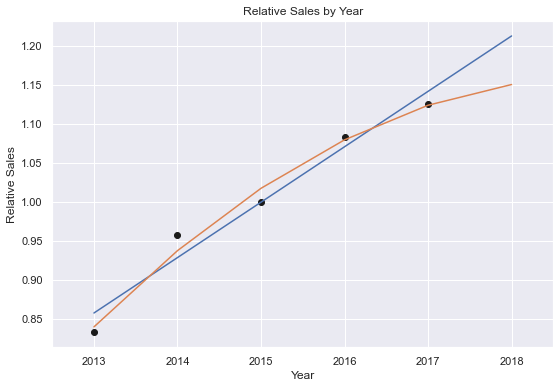

2018 Relative Sales by Degree-1 (Linear) Fit = 1.2132
2018 Relative Sales by Degree-2 (Quadratic) Fit = 1.1509


In [13]:
store_item_table = pd.pivot_table(data, index='store', columns='item',
                                  values='sales', aggfunc=np.mean)
display(store_item_table)

# Monthly pattern
month_table = pd.pivot_table(data, index='month', values='sales', aggfunc=np.mean)
month_table.sales /= grand_avg

# Day of week pattern
dow_table = pd.pivot_table(data, index='dayofweek', values='sales', aggfunc=np.mean)
dow_table.sales /= grand_avg

# Yearly growth pattern
year_table = pd.pivot_table(data, index='year', values='sales', aggfunc=np.mean)
year_table /= grand_avg

years = np.arange(2013, 2019)
annual_sales_avg = year_table.values.squeeze()

p1 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 1))
p2 = np.poly1d(np.polyfit(years[:-1], annual_sales_avg, 2))

plt.figure(figsize=(8,6))
plt.plot(years[:-1], annual_sales_avg, 'ko')
plt.plot(years, p1(years), 'C0-')
plt.plot(years, p2(years), 'C1-')
plt.xlim(2012.5, 2018.5)
plt.title("Relative Sales by Year")
plt.ylabel("Relative Sales")
plt.xlabel("Year")
plt.show()

print(f"2018 Relative Sales by Degree-1 (Linear) Fit = {p1(2018):.4f}")
print(f"2018 Relative Sales by Degree-2 (Quadratic) Fit = {p2(2018):.4f}")

# We pick the quadratic fit
annual_growth = p2

# Arima

In [19]:
train = train[(train['store']==1) & (train['item'] == 1)]

In [20]:
train

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,27,12,2017,2
1822,2017-12-28,1,1,19,28,12,2017,3
1823,2017-12-29,1,1,15,29,12,2017,4
1824,2017-12-30,1,1,27,30,12,2017,5


In [21]:
arima_train = train[train.date < '2017-01-01']
arima_train

,date,store,item,sales,day,month,year,dayofweek
0,2013-01-01,1,1,13,1,1,2013,1
1,2013-01-02,1,1,11,2,1,2013,2
2,2013-01-03,1,1,14,3,1,2013,3
3,2013-01-04,1,1,13,4,1,2013,4
4,2013-01-05,1,1,10,5,1,2013,5
...,...,...,...,...,...,...,...,...
1456,2016-12-27,1,1,10,27,12,2016,1
1457,2016-12-28,1,1,16,28,12,2016,2
1458,2016-12-29,1,1,21,29,12,2016,3
1459,2016-12-30,1,1,24,30,12,2016,4


In [29]:
arima_test = train[train.date >= '2017-01-01']
arima_test

,date,store,item,sales,day,month,year,dayofweek
1461,2017-01-01,1,1,19,1,1,2017,6
1462,2017-01-02,1,1,15,2,1,2017,0
1463,2017-01-03,1,1,10,3,1,2017,1
1464,2017-01-04,1,1,16,4,1,2017,2
1465,2017-01-05,1,1,14,5,1,2017,3
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,27,12,2017,2
1822,2017-12-28,1,1,19,28,12,2017,3
1823,2017-12-29,1,1,15,29,12,2017,4
1824,2017-12-30,1,1,27,30,12,2017,5


## AR1

In [47]:
#averagesales by store and item for 1 year
ar1 = ARIMA(arima_train['sales'], order = (1,0,0)).fit()
trainpreds = ar1.predict()

In [31]:
testpreds = ar1.forecast(365)

In [32]:
trainpreds

0       19.412405
1       16.550813
2       15.658295
3       16.997072
4       16.550813
          ...    
1456    17.889589
1457    15.212036
1458    17.889589
1459    20.120883
1460    21.459660
Name: predicted_mean, Length: 1461, dtype: float64

In [33]:
testpreds

1461    16.997072
1462    18.334541
1463    18.931399
1464    19.197752
1465    19.316614
          ...    
1821    19.412405
1822    19.412405
1823    19.412405
1824    19.412405
1825    19.412405
Name: predicted_mean, Length: 365, dtype: float64

In [34]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1461
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -4661.669
Date:                Wed, 10 Nov 2021   AIC                           9329.338
Time:                        16:35:30   BIC                           9345.199
Sample:                             0   HQIC                          9335.255
                               - 1461                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.4124      0.291     66.620      0.000      18.841      19.984
ar.L1          0.4463      0.023     19.171      0.000       0.401       0.492
sigma2        34.5860      1.206     28.666      0.000      32.221      36.951
===================================================================================
Ljung-Box (L1) (Q):                  12.45   Jarque-Bera (JB):                29.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
print('Train RMSE: ', mean_squared_error(arima_train['sales'], trainpreds)**0.5)
print('Test RMSE: ', mean_squared_error(arima_test['sales'], testpreds)**0.5)

Train RMSE:  5.881460204876675
Test RMSE:  7.4734261674939155


In [44]:
trainpreds

0       19.412405
1       16.550813
2       15.658295
3       16.997072
4       16.550813
          ...    
1456    17.889589
1457    15.212036
1458    17.889589
1459    20.120883
1460    21.459660
Name: predicted_mean, Length: 1461, dtype: float64

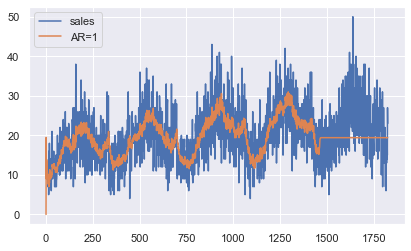

<Figure size 2160x1152 with 0 Axes>

In [54]:
plt.plot(train['sales'], label='sales')
plt.plot(trainpreds.append(testpreds), label='AR=1')
plt.legend()
plt.figure(figsize=(30, 16))
plt.show();

## Arima 1,2,4

In [50]:
ar2 = ARIMA(arima_train['sales'], order = (1,2,4)).fit()
ar2preds = ar2.predict()

In [51]:
ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1461
Model:                 ARIMA(1, 2, 4)   Log Likelihood               -4501.911
Date:                Wed, 10 Nov 2021   AIC                           9015.822
Time:                        16:54:55   BIC                           9047.535
Sample:                             0   HQIC                          9027.653
                               - 1461                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9931      0.005   -188.297      0.000      -1.003      -0.983
ma.L1         -0.8370      0.034    -24.456      0.000      -0.904      -0.770
ma.L2         -1.0765      0.046    -23.218      0.000      -1.167      -0.986
ma.L3          0.8381      0.029     28.492      0.000       0.780       0.896
ma.L4          0.0784      0.027      2.941      0.003       0.026       0.131
sigma2        27.8204      1.059     26.262      0.000      25.744      29.897
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                16.00
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

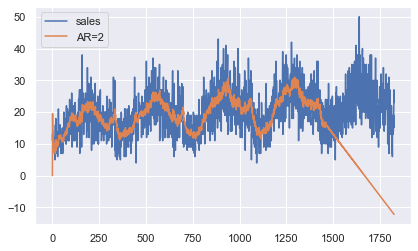

In [59]:
plt.plot(train['sales'], label='sales')
plt.plot(ar2preds.append(ar2.forecast(365)), label='AR=2')
plt.legend()
plt.show()

In [62]:
print('Train RMSE: ', mean_squared_error(arima_train['sales'], ar2preds)**0.5)
print('Test RMSE: ', mean_squared_error(arima_test['sales'], ar2.forecast(365))**0.5)

Train RMSE:  5.294034846283807
Test RMSE:  23.307674178244053


## Arima 4,3,3

In [56]:
ar3 = ARIMA(arima_train['sales'], order = (4,3,3)).fit()
ar3preds = ar3.predict()

In [57]:
ar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1461
Model:                 ARIMA(4, 3, 3)   Log Likelihood               -4651.549
Date:                Wed, 10 Nov 2021   AIC                           9319.098
Time:                        16:58:50   BIC                           9361.377
Sample:                             0   HQIC                          9334.871
                               - 1461                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6204      0.027    -59.382      0.000      -1.674      -1.567
ar.L2         -1.0402      0.049    -21.191      0.000      -1.136      -0.944
ar.L3         -0.6557      0.048    -13.685      0.000      -0.750      -0.562
ar.L4         -0.2387      0.026     -9.264      0.000      -0.289      -0.188
ma.L1         -0.9960      0.155     -6.408      0.000      -1.301      -0.691
ma.L2         -0.9999      0.308     -3.242      0.001      -1.604      -0.395
ma.L3          0.9959      0.155      6.426      0.000       0.692       1.300
sigma2        33.8623      5.271      6.424      0.000      23.531      44.194
===================================================================================
Ljung-Box (L1) (Q):                   3.25   Jarque-Bera (JB):                23.20
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

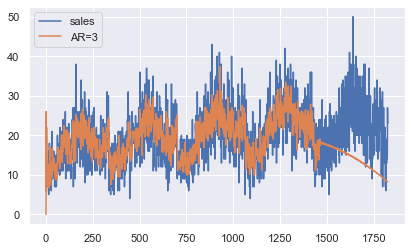

In [64]:
plt.plot(train['sales'], label='sales')
plt.plot(ar3preds.append(ar3.forecast(365)), label='AR=3')
plt.legend()
plt.show()

In [63]:
print('Train RMSE: ', mean_squared_error(arima_train['sales'], ar3preds)**0.5)
print('Test RMSE: ', mean_squared_error(arima_test['sales'], ar3.forecast(365))**0.5)

Train RMSE:  5.878176859562061
Test RMSE:  11.281404718158552


# XGB Model

In [36]:
xgb_train = train.loc[~train.sales.isna()]
print("xgb train", train.shape)

xgb train (1826, 8)


In [38]:
col = [i for i in xgb_train.columns if i not in ['date', 'id']]
y = 'sales'

In [40]:
X_train, X_test, y_train, y_test = train_test_split(xgb_train[col],xgb_train[y], test_size=0.15, random_state=42)

In [41]:
def XGB_regressor(X_train, y_train, X_test, y_test, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'reg:linear'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['eval_metric'] = 'mae'
    param['min_child_weight'] = 1
    param['subsample'] = 0.8
    param['colsample_bytree'] = 0.8
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())

    xgtrain = xgb.DMatrix(X_train, label=y_train)

    if y_test is not None:
        xgtest = xgb.DMatrix(X_test, label=y_test)
        watchlist = [ (xgtrain,'train_df'), (xgtest, 'test_df') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(X_test)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model    

In [42]:
model = XGB_regressor(X_train, y_train, X_test, y_test)
y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit = model.best_ntree_limit)

[16:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:43:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train_df-mae:17.60531	test_df-mae:17.16315
Multiple eval metrics have been passed: 'test_df-mae' will be used for early stopping.

Will train until test_df-mae hasn't improved in 20 rounds.
[1]	train_df-mae:15.85795	test_df-mae:15.45937
[2]	train_df-mae:14.28324	test_df-mae:13.92336
[3]	train_df-mae:12.86653	test_df-mae:12.54083
[4]	train_df-mae:11.59062	test_df-mae:11.29012
[5]	train_df-mae:10.43646	test_df-mae:10.17354
[6]	train_

[162]	train_df-mae:0.06366	test_df-mae:0.17019
[163]	train_df-mae:0.06321	test_df-mae:0.16981
[164]	train_df-mae:0.06299	test_df-mae:0.16968
[165]	train_df-mae:0.06242	test_df-mae:0.16927
[166]	train_df-mae:0.06202	test_df-mae:0.16898
[167]	train_df-mae:0.06169	test_df-mae:0.16858
[168]	train_df-mae:0.06135	test_df-mae:0.16861
[169]	train_df-mae:0.06085	test_df-mae:0.16794
[170]	train_df-mae:0.06055	test_df-mae:0.16746
[171]	train_df-mae:0.06033	test_df-mae:0.16711
[172]	train_df-mae:0.05999	test_df-mae:0.16698
[173]	train_df-mae:0.05973	test_df-mae:0.16649
[174]	train_df-mae:0.05919	test_df-mae:0.16588
[175]	train_df-mae:0.05890	test_df-mae:0.16573
[176]	train_df-mae:0.05869	test_df-mae:0.16544
[177]	train_df-mae:0.05818	test_df-mae:0.16505
[178]	train_df-mae:0.05797	test_df-mae:0.16480
[179]	train_df-mae:0.05767	test_df-mae:0.16461
[180]	train_df-mae:0.05745	test_df-mae:0.16432
[181]	train_df-mae:0.05689	test_df-mae:0.16343
[182]	train_df-mae:0.05665	test_df-mae:0.16324
[183]	train_d

[337]	train_df-mae:0.02631	test_df-mae:0.14485
[338]	train_df-mae:0.02618	test_df-mae:0.14478
[339]	train_df-mae:0.02609	test_df-mae:0.14468
[340]	train_df-mae:0.02604	test_df-mae:0.14459
[341]	train_df-mae:0.02594	test_df-mae:0.14454
[342]	train_df-mae:0.02580	test_df-mae:0.14444
[343]	train_df-mae:0.02570	test_df-mae:0.14442
[344]	train_df-mae:0.02551	test_df-mae:0.14436
[345]	train_df-mae:0.02544	test_df-mae:0.14434
[346]	train_df-mae:0.02530	test_df-mae:0.14427
[347]	train_df-mae:0.02521	test_df-mae:0.14425
[348]	train_df-mae:0.02510	test_df-mae:0.14420
[349]	train_df-mae:0.02496	test_df-mae:0.14417
[350]	train_df-mae:0.02486	test_df-mae:0.14410
[351]	train_df-mae:0.02475	test_df-mae:0.14411
[352]	train_df-mae:0.02466	test_df-mae:0.14397
[353]	train_df-mae:0.02458	test_df-mae:0.14394
[354]	train_df-mae:0.02449	test_df-mae:0.14381
[355]	train_df-mae:0.02439	test_df-mae:0.14374
[356]	train_df-mae:0.02426	test_df-mae:0.14366
[357]	train_df-mae:0.02421	test_df-mae:0.14361
[358]	train_d

In [43]:
#predictions = model.predict(xgb.DMatrix(test_df[col]))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("score: {}".format(rmse))

score: 0.20333306960738257


# XGB with Gridsearch

In [72]:
paramGrid = {"subsample" : [0.5, 0.8]}

fit_params={"early_stopping_rounds":42, 
            "eval_metric" : "mae", 
            "eval_set" : [[X_test, y_test]]}

model = xgb.XGBRegressor()
gridsearch = GridSearchCV(model, paramGrid, verbose=0,
         cv=TimeSeriesSplit(n_splits=3).get_n_splits([X_train, y_train]))
gridsearch.fit(X_train, y_train, **fit_params)

[0]	validation_0-mae:13.40566
Will train until validation_0-mae hasn't improved in 42 rounds.
[1]	validation_0-mae:9.45858
[2]	validation_0-mae:6.66502
[3]	validation_0-mae:4.72338
[4]	validation_0-mae:3.32392
[5]	validation_0-mae:2.34599
[6]	validation_0-mae:1.66042
[7]	validation_0-mae:1.16241
[8]	validation_0-mae:0.82230
[9]	validation_0-mae:0.58548
[10]	validation_0-mae:0.41960
[11]	validation_0-mae:0.29724
[12]	validation_0-mae:0.21204
[13]	validation_0-mae:0.15365
[14]	validation_0-mae:0.11341
[15]	validation_0-mae:0.08385
[16]	validation_0-mae:0.06093
[17]	validation_0-mae:0.04697
[18]	validation_0-mae:0.03830
[19]	validation_0-mae:0.03229
[20]	validation_0-mae:0.02849
[21]	validation_0-mae:0.02700
[22]	validation_0-mae:0.02525
[23]	validation_0-mae:0.02521
[24]	validation_0-mae:0.02532
[25]	validation_0-mae:0.02481
[26]	validation_0-mae:0.02359
[27]	validation_0-mae:0.02383
[28]	validation_0-mae:0.02372
[29]	validation_0-mae:0.02380
[30]	validation_0-mae:0.02283
[31]	validation

[68]	validation_0-mae:0.01198
[69]	validation_0-mae:0.01192
[70]	validation_0-mae:0.01182
[71]	validation_0-mae:0.01179
[72]	validation_0-mae:0.01166
[73]	validation_0-mae:0.01166
[74]	validation_0-mae:0.01153
[75]	validation_0-mae:0.01147
[76]	validation_0-mae:0.01139
[77]	validation_0-mae:0.01143
[78]	validation_0-mae:0.01129
[79]	validation_0-mae:0.01129
[80]	validation_0-mae:0.01133
[81]	validation_0-mae:0.01123
[82]	validation_0-mae:0.01115
[83]	validation_0-mae:0.01112
[84]	validation_0-mae:0.01117
[85]	validation_0-mae:0.01115
[86]	validation_0-mae:0.01106
[87]	validation_0-mae:0.01112
[88]	validation_0-mae:0.01112
[89]	validation_0-mae:0.01119
[90]	validation_0-mae:0.01108
[91]	validation_0-mae:0.01104
[92]	validation_0-mae:0.01104
[93]	validation_0-mae:0.01102
[94]	validation_0-mae:0.01098
[95]	validation_0-mae:0.01098
[96]	validation_0-mae:0.01099
[97]	validation_0-mae:0.01097
[98]	validation_0-mae:0.01096
[99]	validation_0-mae:0.01090
[0]	validation_0-mae:13.38568
Will train

[36]	validation_0-mae:0.01121
[37]	validation_0-mae:0.01104
[38]	validation_0-mae:0.01100
[39]	validation_0-mae:0.01091
[40]	validation_0-mae:0.01087
[41]	validation_0-mae:0.01081
[42]	validation_0-mae:0.01077
[43]	validation_0-mae:0.01053
[44]	validation_0-mae:0.01048
[45]	validation_0-mae:0.01041
[46]	validation_0-mae:0.01026
[47]	validation_0-mae:0.01016
[48]	validation_0-mae:0.01011
[49]	validation_0-mae:0.01006
[50]	validation_0-mae:0.00997
[51]	validation_0-mae:0.00994
[52]	validation_0-mae:0.00994
[53]	validation_0-mae:0.00984
[54]	validation_0-mae:0.00983
[55]	validation_0-mae:0.00983
[56]	validation_0-mae:0.00981
[57]	validation_0-mae:0.00982
[58]	validation_0-mae:0.00978
[59]	validation_0-mae:0.00976
[60]	validation_0-mae:0.00971
[61]	validation_0-mae:0.00969
[62]	validation_0-mae:0.00969
[63]	validation_0-mae:0.00962
[64]	validation_0-mae:0.00963
[65]	validation_0-mae:0.00962
[66]	validation_0-mae:0.00962
[67]	validation_0-mae:0.00961
[68]	validation_0-mae:0.00958
[69]	valid

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [75]:
gridsearch.best_params_

{'subsample': 0.5}

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("score: {}".format(rmse))

In [99]:
paramGrid = {"subsample" : [0.5],
            
            'criterion': ['gini', 'entropy'],
        
            }

fit_params={"early_stopping_rounds":42,
            "eval_metric" : "mae", 
            "eval_set" : [[X_test, y_test]],
           }

model = xgb.XGBRegressor()
gridsearch = GridSearchCV(model, paramGrid, verbose=0,
         cv=TimeSeriesSplit(n_splits=3).get_n_splits([X_train, y_train]))
gridsearch.fit(X_train, y_train, **fit_params)

[00:01:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mae:13.40566
Will train until validation_0-mae hasn't improved in 42 rounds.
[1]	validation_0-mae:9.45858
[2]	validation_0-mae:6.66502
[3]	validation_0-mae:4.72338
[4]	validation_0-mae:3.32392
[5]	validation_0-mae:2.34599
[6]	validation_0-mae:1.66042
[7]	validation_0-mae:1.16241
[8]	validation_0-mae:0.82230
[9]	validation_0-mae:0.58548
[10]	validation_0-mae:0.41960
[11]	validation_0-mae:0.29724
[12]	validation_0-mae:0.21204
[13]	validation_0-mae:0.15365
[14]	validation_0-mae:0.11341
[15]	validation_0-mae:0.08385
[16]	validation_0-mae:0.06093
[17]	validation_0-mae:0.04697
[18]	validation_0-

[29]	validation_0-mae:0.02242
[30]	validation_0-mae:0.02219
[31]	validation_0-mae:0.02130
[32]	validation_0-mae:0.02089
[33]	validation_0-mae:0.02047
[34]	validation_0-mae:0.01978
[35]	validation_0-mae:0.01949
[36]	validation_0-mae:0.01896
[37]	validation_0-mae:0.01890
[38]	validation_0-mae:0.01891
[39]	validation_0-mae:0.01885
[40]	validation_0-mae:0.01821
[41]	validation_0-mae:0.01807
[42]	validation_0-mae:0.01751
[43]	validation_0-mae:0.01717
[44]	validation_0-mae:0.01688
[45]	validation_0-mae:0.01663
[46]	validation_0-mae:0.01612
[47]	validation_0-mae:0.01518
[48]	validation_0-mae:0.01475
[49]	validation_0-mae:0.01473
[50]	validation_0-mae:0.01430
[51]	validation_0-mae:0.01403
[52]	validation_0-mae:0.01393
[53]	validation_0-mae:0.01387
[54]	validation_0-mae:0.01383
[55]	validation_0-mae:0.01369
[56]	validation_0-mae:0.01357
[57]	validation_0-mae:0.01313
[58]	validation_0-mae:0.01305
[59]	validation_0-mae:0.01296
[60]	validation_0-mae:0.01297
[61]	validation_0-mae:0.01283
[62]	valid

[73]	validation_0-mae:0.00566
[74]	validation_0-mae:0.00564
[75]	validation_0-mae:0.00565
[76]	validation_0-mae:0.00566
[77]	validation_0-mae:0.00566
[78]	validation_0-mae:0.00558
[79]	validation_0-mae:0.00557
[80]	validation_0-mae:0.00558
[81]	validation_0-mae:0.00553
[82]	validation_0-mae:0.00546
[83]	validation_0-mae:0.00545
[84]	validation_0-mae:0.00545
[85]	validation_0-mae:0.00544
[86]	validation_0-mae:0.00541
[87]	validation_0-mae:0.00542
[88]	validation_0-mae:0.00543
[89]	validation_0-mae:0.00543
[90]	validation_0-mae:0.00541
[91]	validation_0-mae:0.00541
[92]	validation_0-mae:0.00540
[93]	validation_0-mae:0.00539
[94]	validation_0-mae:0.00539
[95]	validation_0-mae:0.00537
[96]	validation_0-mae:0.00539
[97]	validation_0-mae:0.00538
[98]	validation_0-mae:0.00537
[99]	validation_0-mae:0.00536
[00:01:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { criterion } might not be used.

  This may not be accurate due to some par

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para